### Load data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix

from src.utils.io import read_json
from conf_prediction.utils import *
from conf_prediction.abs_error import conformal_calibrate
from conf_prediction.quantile import *

useg_path = 'results/32/universeg/'
sam_path = 'results/32/sam2.1/'
atlas_path = 'results/8/atlas/'

res_useg = {}
res_sam = {}
res_atlas = {}

datasets = ['hc18', 'jsrt', 'ph2', 'psfhs', 'scd', '3d-ircadb', 'wbc_cv', 'wbc_jtsc', 'isic 2018']

def process_dataset(data):
    real_scores = []
    rca_scores = []
    for x in data:
        # Skip if DSC score is too low
        if np.any(np.array(x['Real score']['Dice']) < 0.05):
            continue

        rca_dice_list = x['RCA score']['Dice']
        skip_rca = False

        for rca_array in rca_dice_list:
            rca_array = np.array(rca_array)
            if rca_array.ndim == 1:
                rca_array = rca_array.reshape(-1, 1)

            # Check if for any column (axis=1), all values are < 0.05
            if np.any(np.all(rca_array < 0.05, axis=0)):
                skip_rca = True
                break

        if skip_rca:
            continue  # Skip this entire entry

        real_scores.append(x['Real score']['Dice'])
        rca_scores.append(np.array([v for v in rca_dice_list]))

    return {'Real score': real_scores, 'RCA score': rca_scores}


for dataset in datasets:
    # Load the data
    sam_data = read_json(sam_path + dataset + '.json')
    useg_data = read_json(useg_path + dataset + '.json')
    atlas_data = read_json(atlas_path + dataset + '.json')

    # Process the data
    res_useg[dataset] = process_dataset(useg_data)
    res_sam[dataset] = process_dataset(sam_data)
    res_atlas[dataset] = process_dataset(atlas_data)


### RCA estimations

In [2]:
results = {}

for dataset in datasets:
    real = np.array(res_sam[dataset]['Real score'])
    rca = np.array(res_sam[dataset]['RCA score']).mean(axis=1)
    
    # Ensure 2D shape for consistency (samples, classes)
    if real.ndim == 1:
        real = real.reshape(-1, 1)
    if rca.ndim == 1:
        rca = rca.reshape(-1, 1)

    abs_error = np.abs(real - rca)
    mae = np.mean(abs_error, axis=0)

    # Per-class correlation
    correlations = []
    for i in range(real.shape[1]):
        corr, _ = pearsonr(real[:, i], rca[:, i])
        correlations.append(corr)

    # Store results as tuples (MAE, Correlation) per class
    results[dataset.upper()] = {
        f'Class {i} MAE': mae[i] for i in range(len(mae))
    } | {
        f'Class {i} Corr': correlations[i] for i in range(len(correlations))
    }

df = pd.DataFrame.from_dict(results, orient='index')
df


,Class 0 MAE,Class 0 Corr,Class 1 MAE,Class 1 Corr
HC18,0.101650,0.853949,NaN,NaN
JSRT,0.029112,0.842900,0.059035,0.907532
PH2,0.115569,0.903683,NaN,NaN
PSFHS,0.118532,0.842446,0.095443,0.744654
SCD,0.160892,0.774185,NaN,NaN
3D-IRCADB,0.100821,0.900218,NaN,NaN
WBC_CV,0.092338,0.847582,0.070475,0.883680
WBC_JTSC,0.065433,0.827034,0.088942,0.733484
ISIC 2018,0.151618,0.618093,NaN,NaN


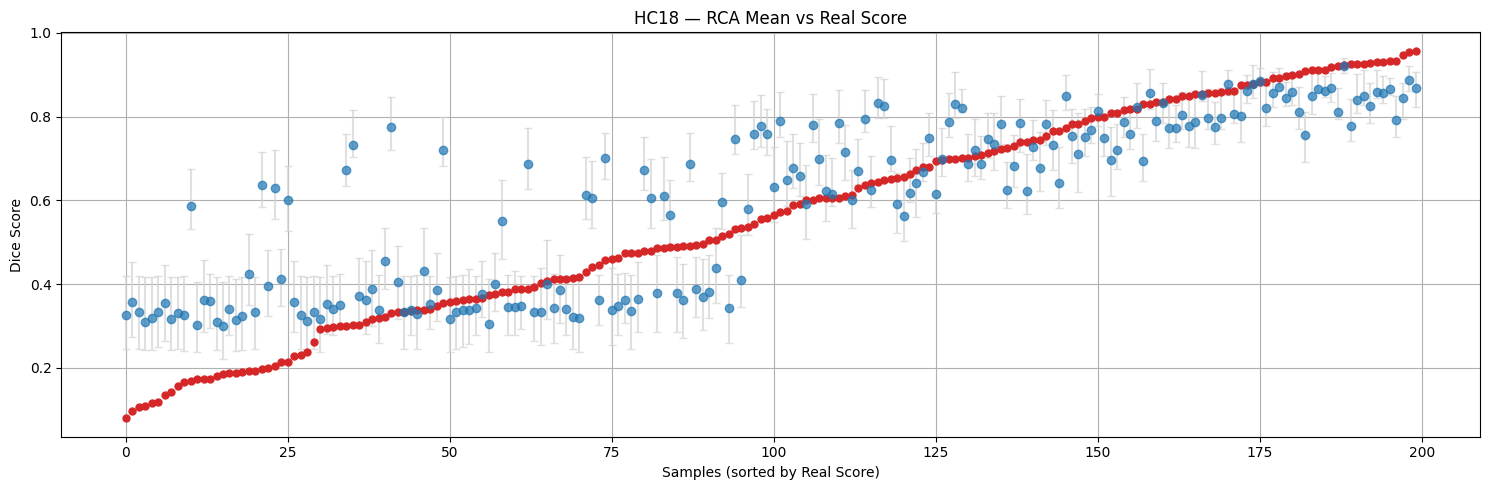

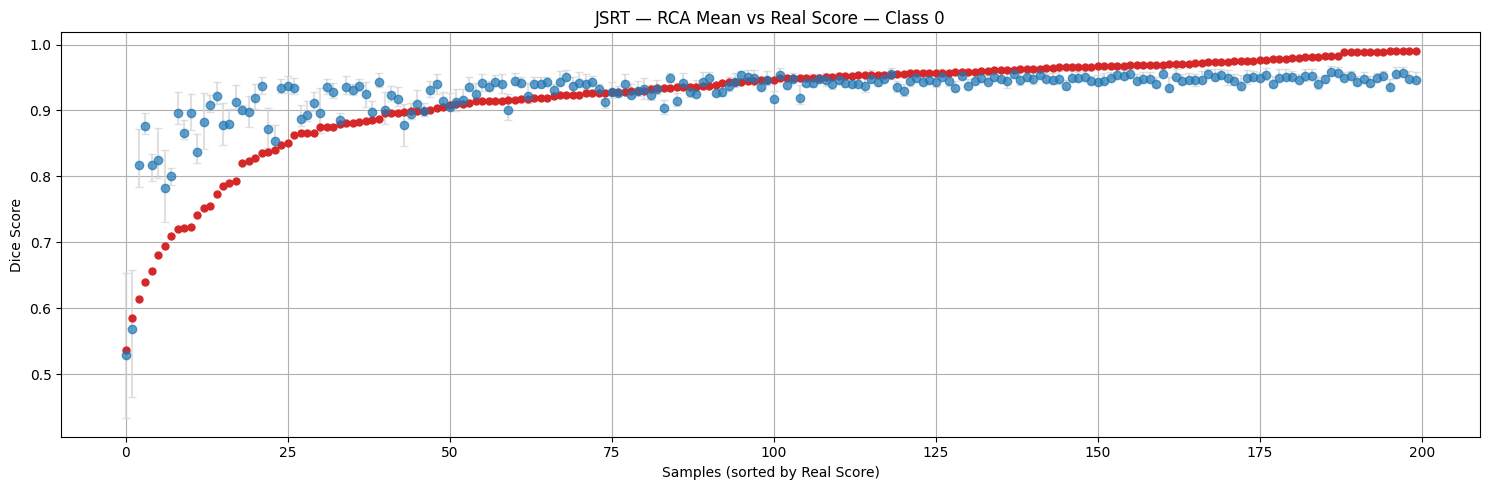

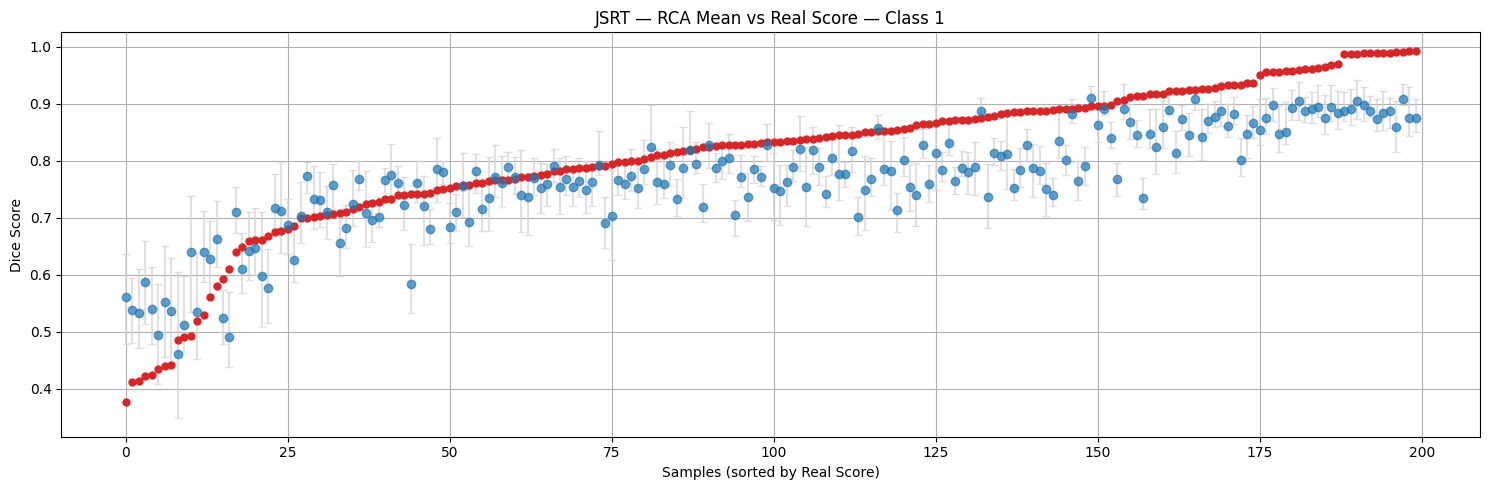

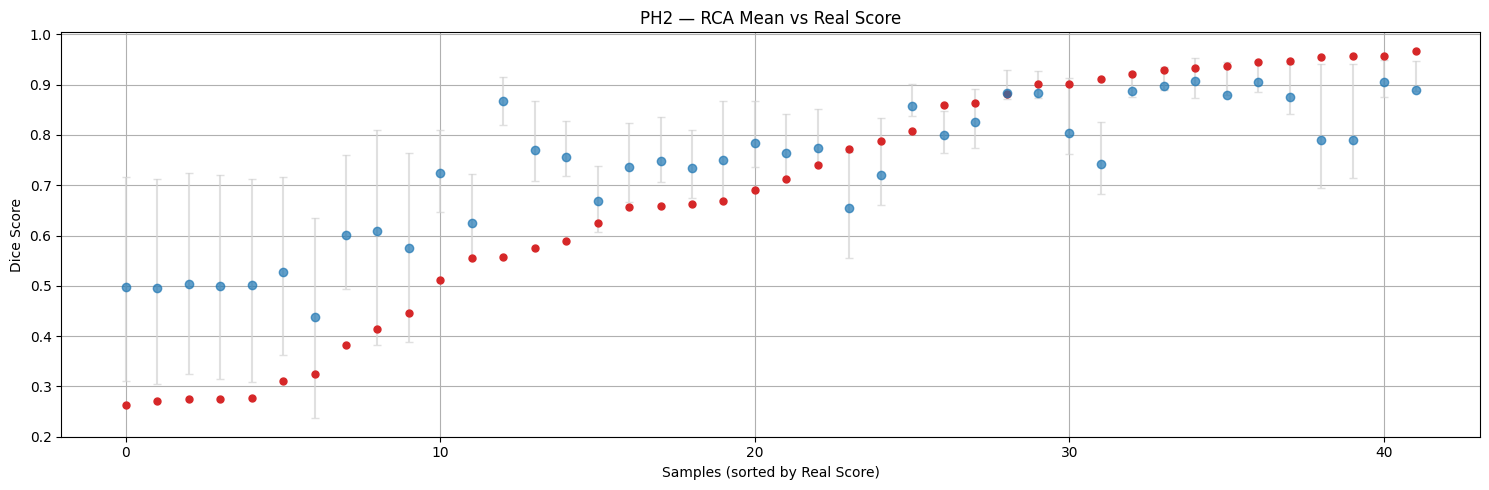

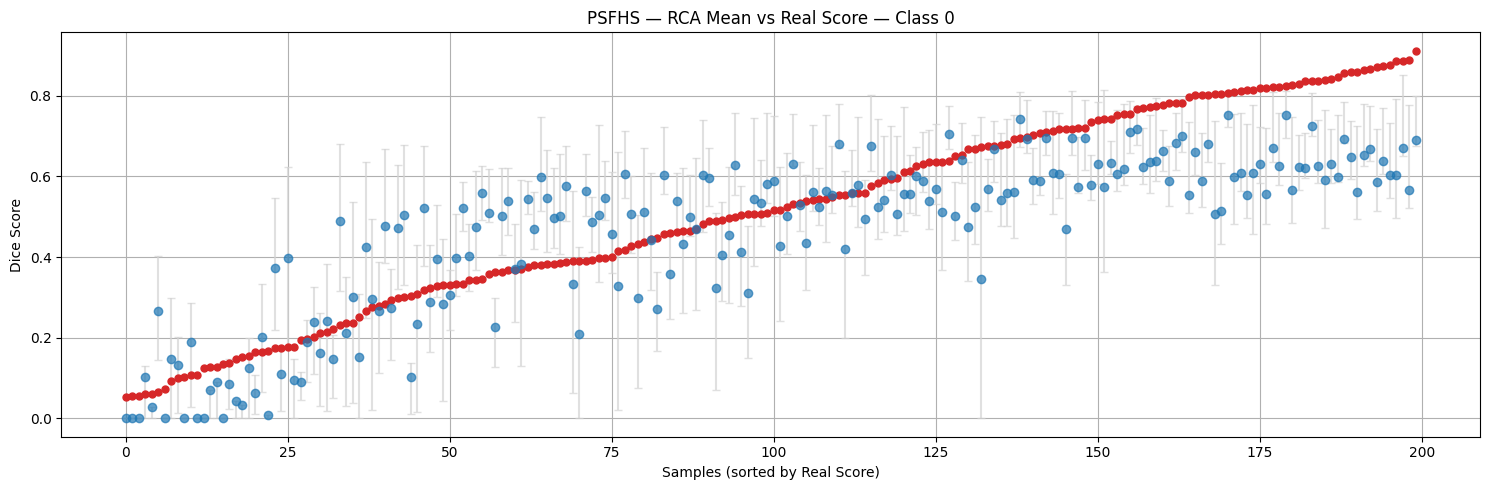

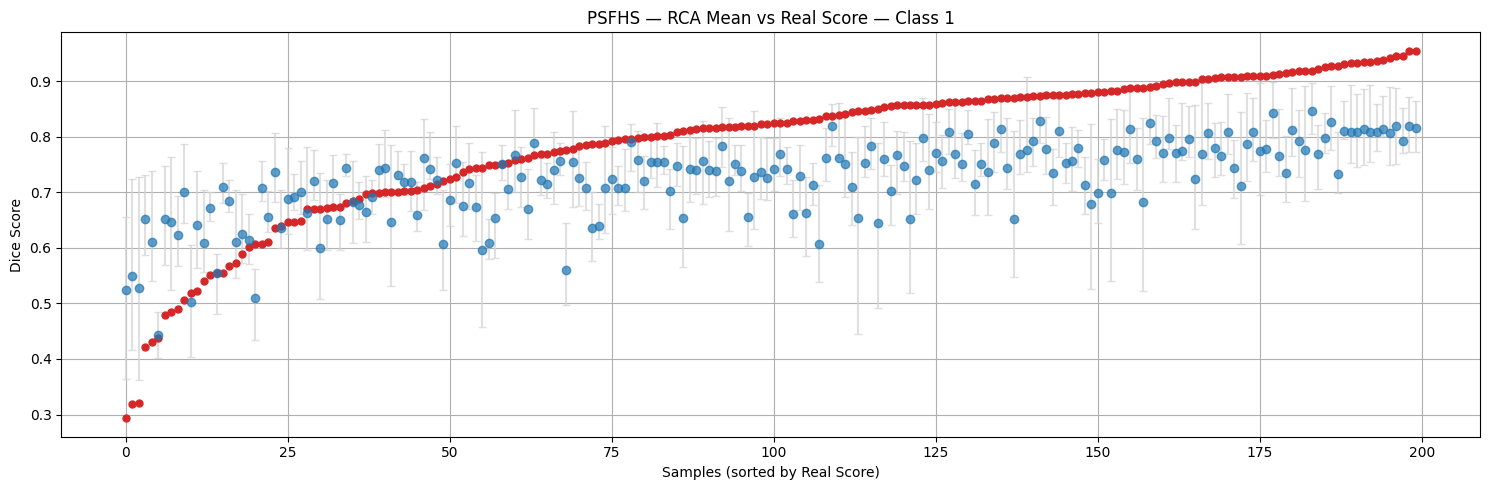

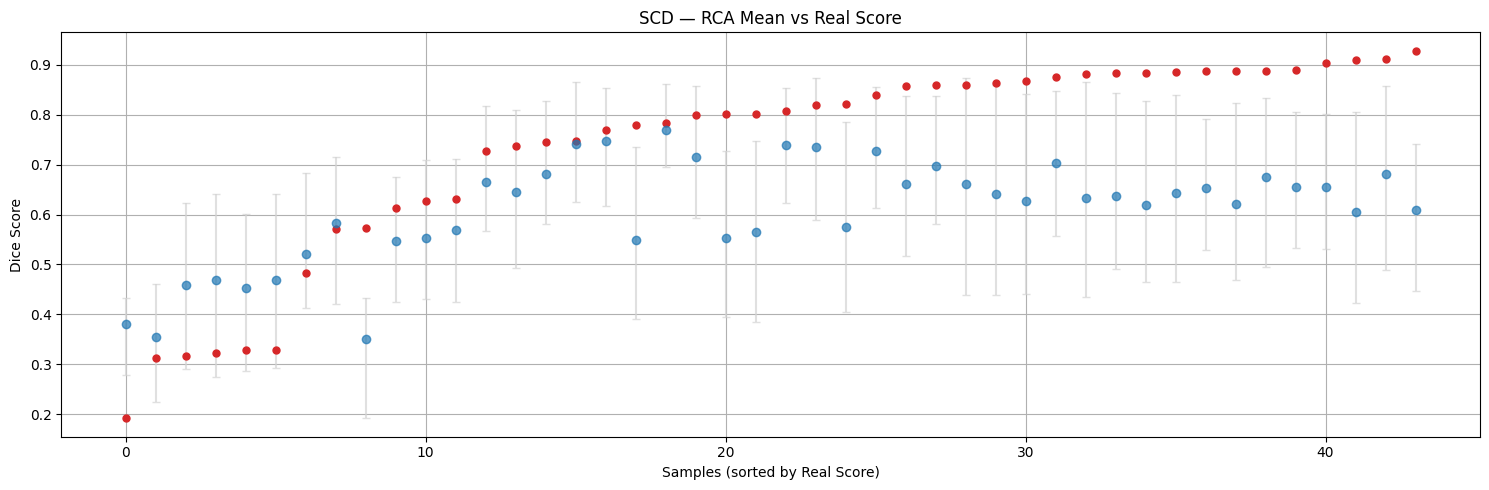

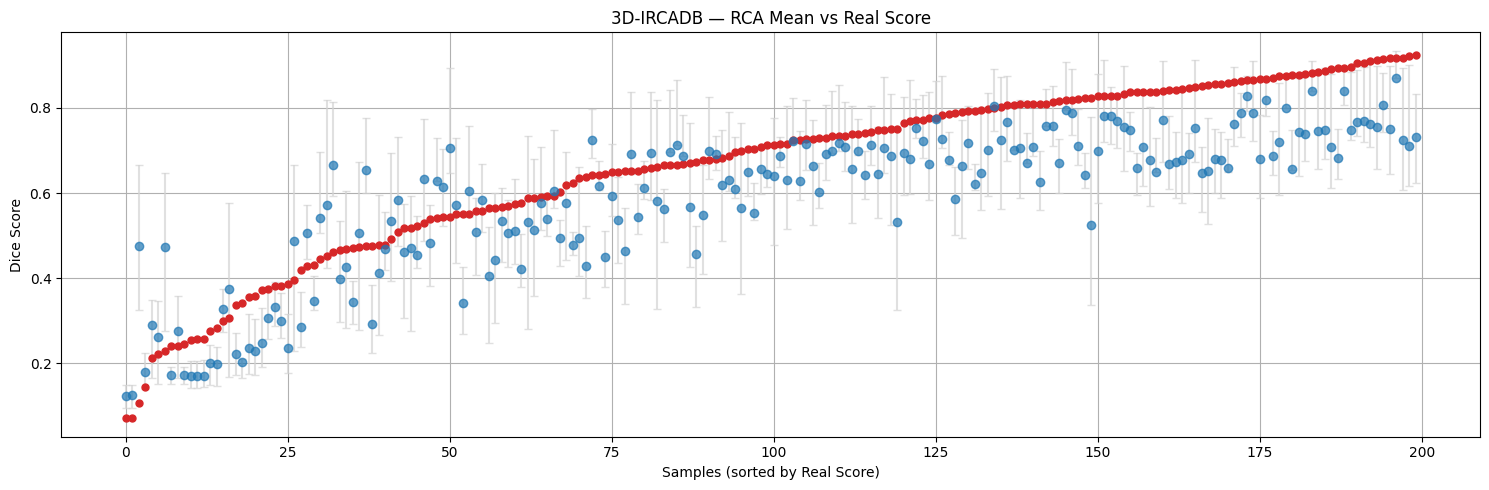

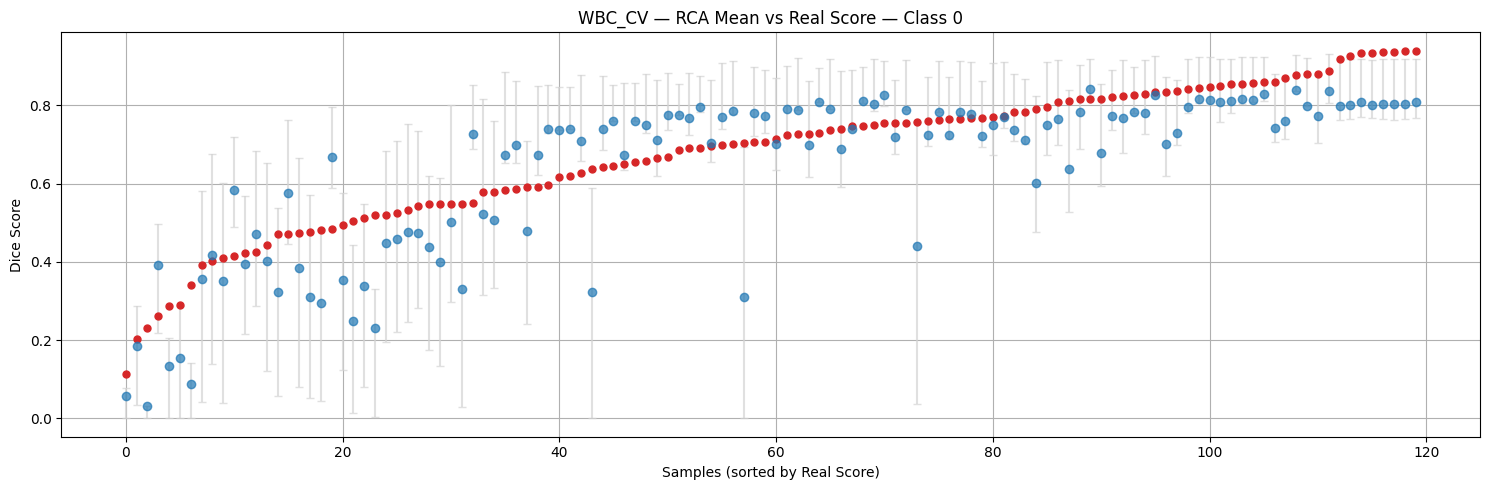

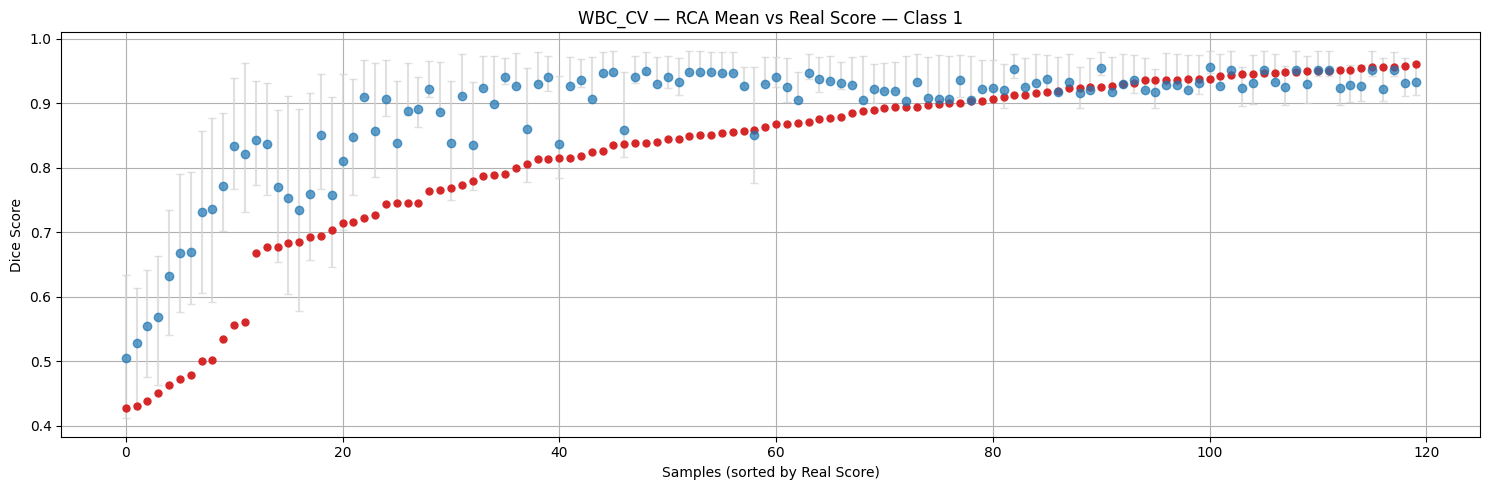

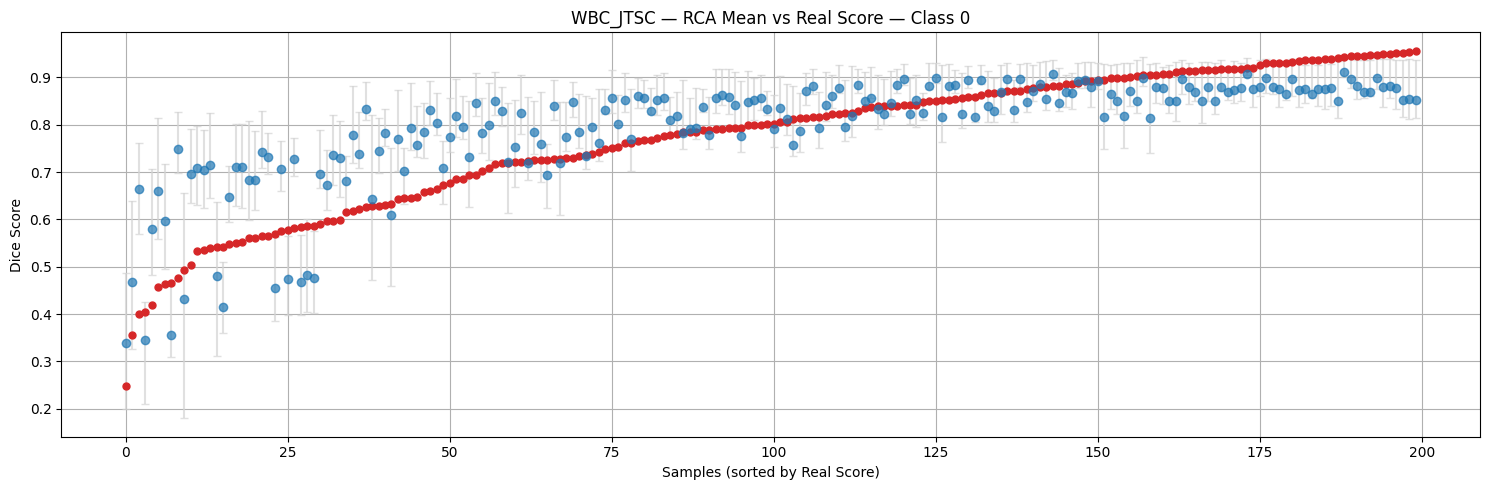

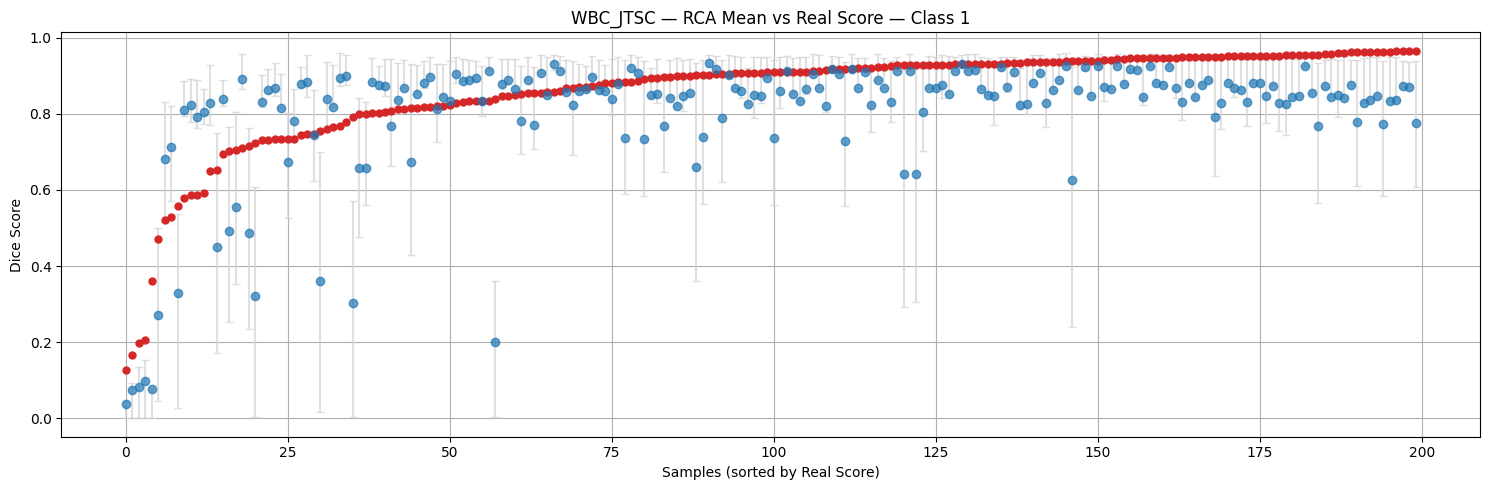

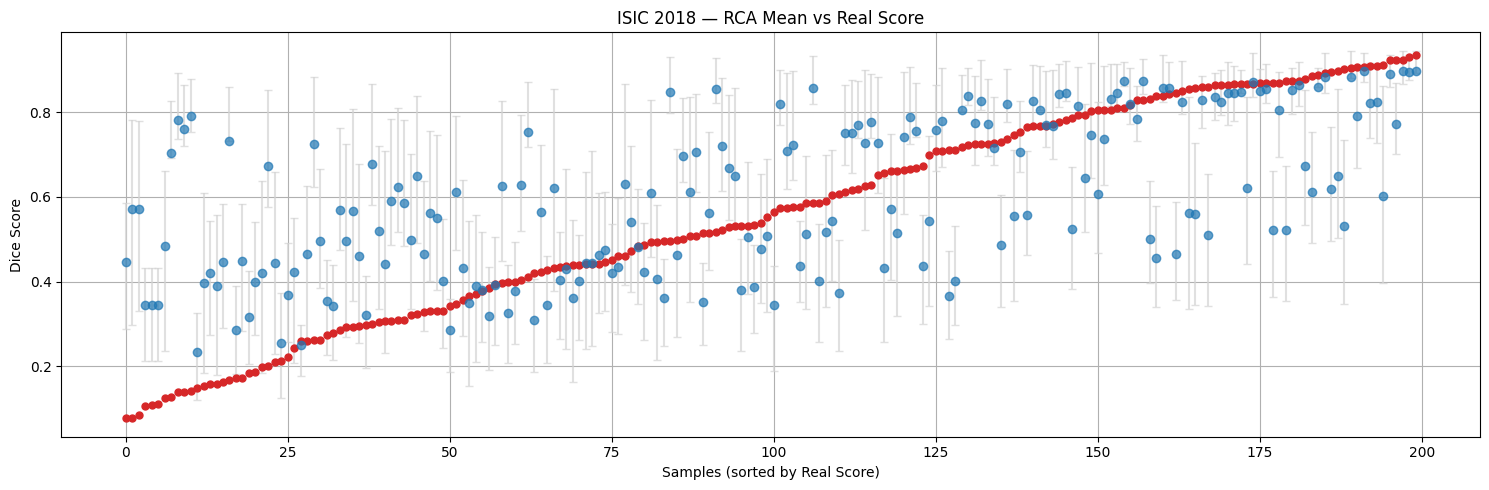

In [3]:
for dataset in datasets:
    plot_rca_range_vs_real(res_sam, dataset, estimator='mean', use_iqr=True, n_samples=200)

### Conformal range prediction

Let $\hat{y}(x) = \{\hat{y}^{(1)}(x), \dots, \hat{y}^{(m)}(x)\}$ be the set of DSC estimates for a given input segmentation $x$.


##### Absolute error based
Define two possible predictors:

- $\hat{y}_{\text{mean}}(x) = \frac{1}{m} \sum_{j=1}^m \hat{y}^{(j)}(x)$  
- $\hat{y}_{\text{max}}(x) = \max_j \hat{y}^{(j)}(x)$

Given a true DSC score $y$ and a predicted score $\hat{y}_\text{pred}(x) \in \{\hat{y}_{\text{mean}}(x), \hat{y}_{\text{max}}(x)\}$, define the nonconformity score as:

$\quad S(x, y) = |y - \hat{y}_\text{pred}(x)| \quad \text{or} \quad S(x, y) = \frac{|y - \hat{y}_\text{pred}(x)|}{\sigma(\hat{y}(x))}$

Where $\sigma(\hat{y}(x))$ is one of:

- **Standard deviation**:  
  $\sigma(\hat{y}(x)) = \sqrt{\frac{1}{m - 1} \sum_{j=1}^m (\hat{y}^{(j)}(x) - \hat{y}_{\text{mean}}(x))^2}$

- **IQR-based**:  
  $\sigma_{\text{IQR}}(\hat{y}(x)) = \frac{Q_3 - Q_1}{1.349}$

- **Trimmed standard deviation**:  
  $\sigma_{\text{trim}}(\hat{y}(x)) = \text{std}\left(\{\hat{y}^{(j)}(x) \mid \hat{y}^{(j)}(x) \geq \text{percentile}_\gamma\}\right)$



Given calibration scores $S_1, \dots, S_n$ and a level $\alpha$, compute:

$\quad \hat{q}_\alpha = \text{Quantile}(S_1, \dots, S_n;\ \frac{(n + 1)(1 - \alpha)}{n})$

Then, the prediction interval for a new input $x$ is:

- Without scaling:
$[\hat{y}_\text{pred}(x) - \hat{q}_\alpha,\ \hat{y}_\text{pred}(x) + \hat{q}_\alpha] \cap [0, 1]$ 

- With scaling:
$[\hat{y}_\text{pred}(x) - \hat{q}_\alpha \cdot \sigma(\hat{y}(x)),\ \hat{y}_\text{pred}(x) + \hat{q}_\alpha \cdot \sigma(\hat{y}(x))] \cap [0, 1]$ 

---
##### Quantile based

We define a prediction interval based on the empirical quantiles $p_\ell$ and $p_h$.
Given a sample of predictions $\hat{y}(x)$,  
define the empirical prediction band as:

$\quad [\hat{q}_\ell(x), \hat{q}_h(x)] = \left[\text{Quantile}(\hat{y}(x),\ p_\ell),\ \text{Quantile}(\hat{y}(x),\ p_h)\right]$

For a calibration set and a level $\alpha$ we compute the non-conformity scores:

$\quad S(x, y) = \max\{\hat{q}_\ell(x) - y,\ y - \hat{q}_h(x)\}$  

We then determine inflation margin from the calibration nonconformity scores:

$Q_{1-\alpha}= \text{Quantile}(S^{(1)}, \dots, S^{(n)};\ 1 - \alpha)$  

Finally, for each test input $x$, we construct the prediction interval as

$\quad \left[\hat{q}_\ell(x) - Q_{1-\alpha}, \ \hat{q}_h(x) + Q_{1-\alpha}\right] \cap [0,1]$

Number of calibration samples: 125


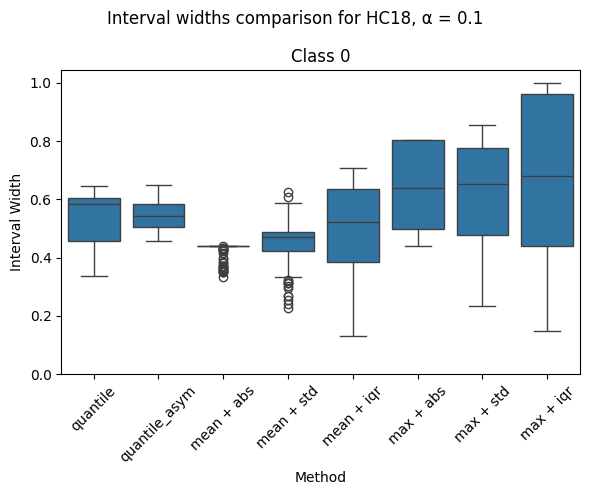

Number of calibration samples: 294


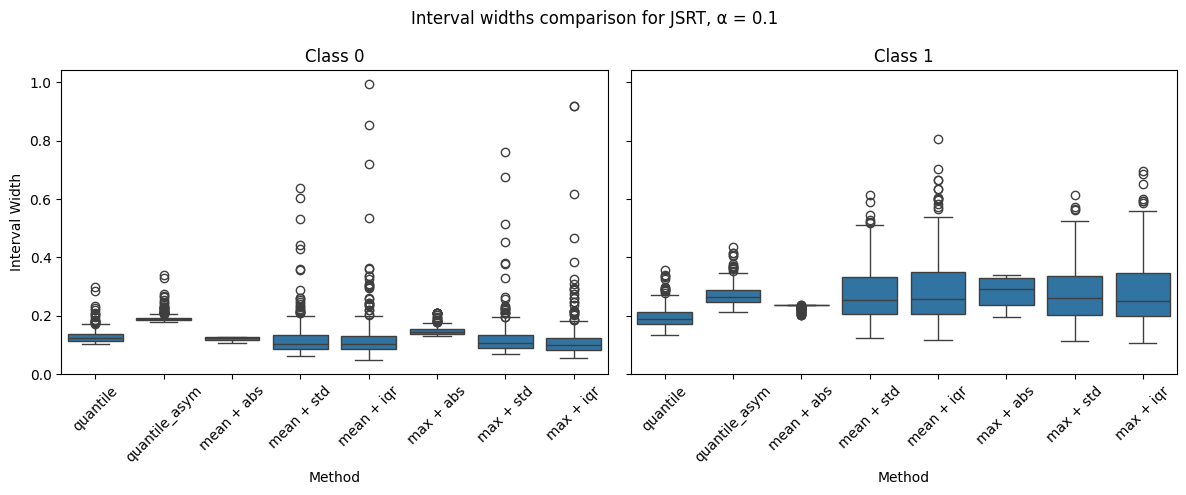

Number of calibration samples: 21


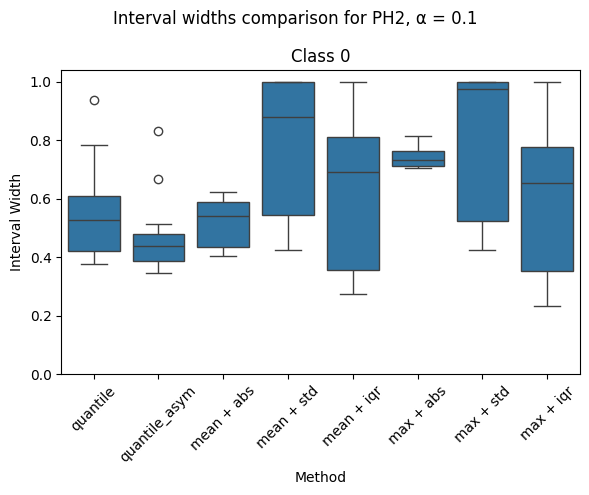

Number of calibration samples: 272


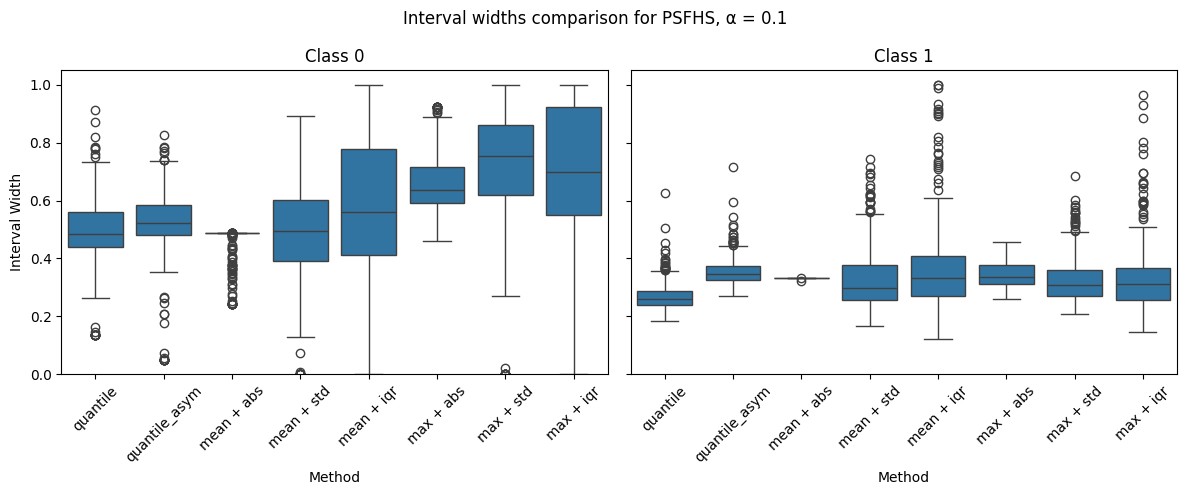

Number of calibration samples: 22


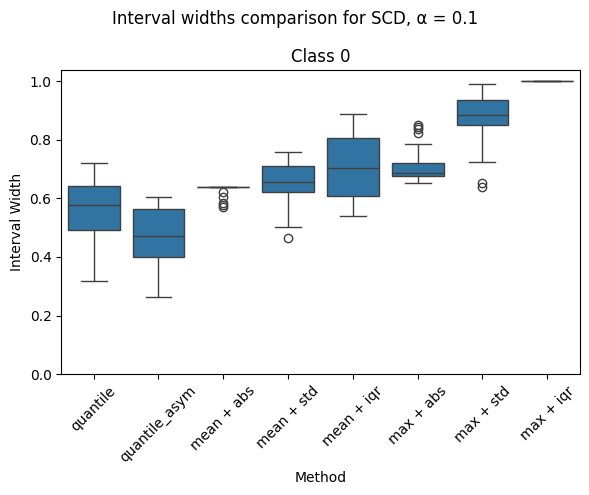

Number of calibration samples: 159


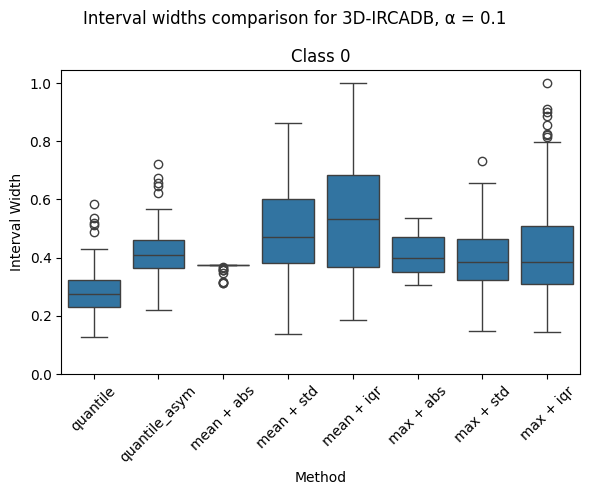

Number of calibration samples: 60


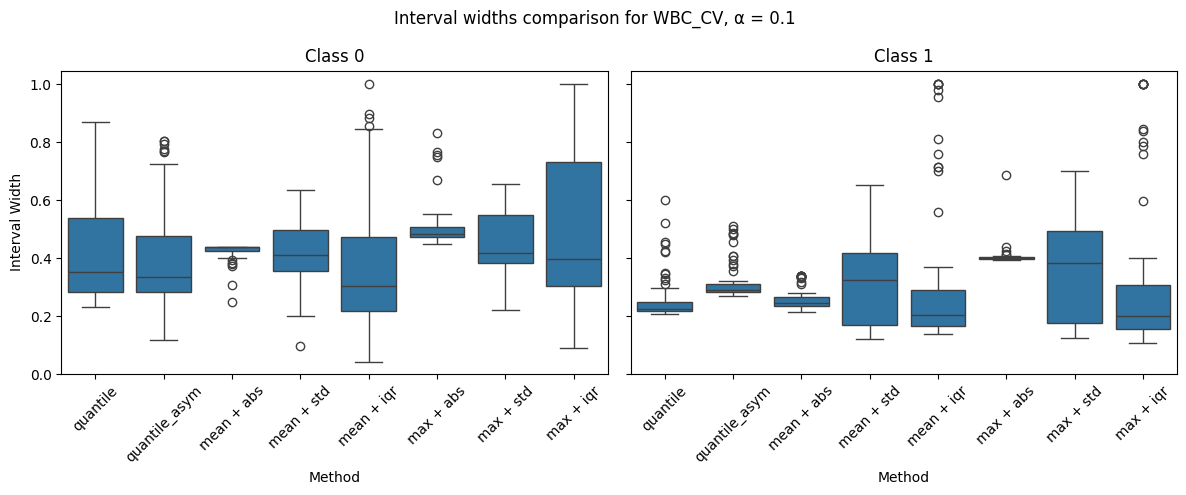

Number of calibration samples: 149


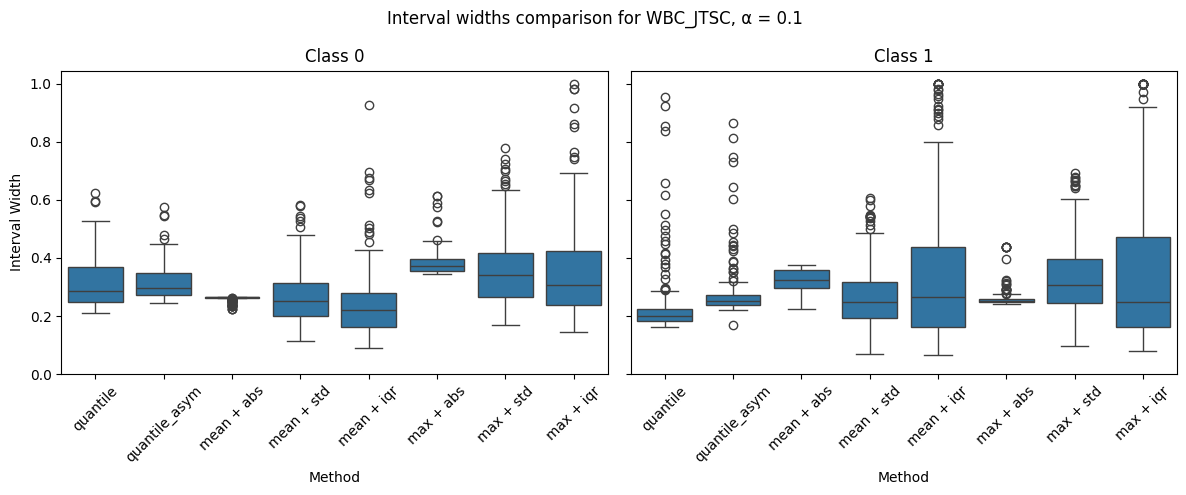

Number of calibration samples: 136


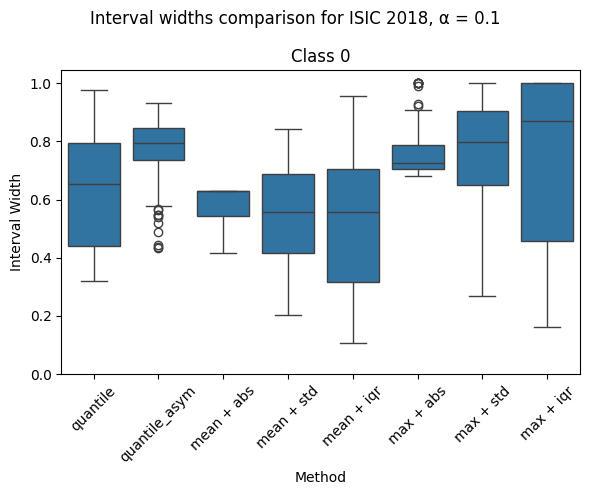

In [4]:
alpha = 0.1
combinations = [(e, s) for e in ['mean', 'max'] for s in ['abs', 'std', 'iqr']]

for dataset in datasets:
    print('Number of calibration samples:', len(res_sam[dataset]['Real score']) // 2)
    conf_results = {}

    # Quantile based
    conf_results['quantile'] = quantile_calibrate(
        res_sam[dataset],
        p_l=0.4, p_h=0.95,
        alpha=alpha
    )


    conf_results['quantile_asym'] = quantile_calibrate_asymm(
        res_sam[dataset],
        p_l=0.4, p_h=0.95,
        alpha_l=0.02, 
        alpha_u=0.08
    )

    # Regression based
    for estimator, sigma_type in combinations:
        label = f'{estimator} + {sigma_type}'
        conf_results[label] = conformal_calibrate(
            res_sam[dataset],
            estimator=estimator,
            sigma_type=sigma_type,
            alpha=alpha,
        )

    # Plot for this dataset
    plot_interval_size(conf_results, title=f'Interval widths comparison for {dataset.upper()}, α = {alpha}')
    
    #plot_coverage_analysis(conf_results, alpha=alpha, conditioning='value',
    #                       title=f'Conditional and marginal coverage for {dataset.upper()}, α = {alpha}')


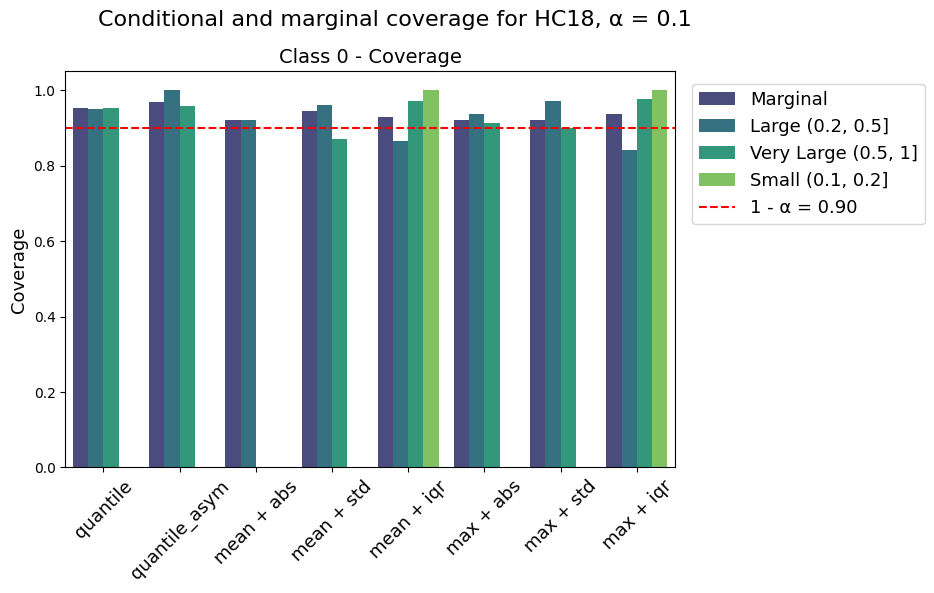

The palette list has more values (5) than needed (4), which may not be intended.


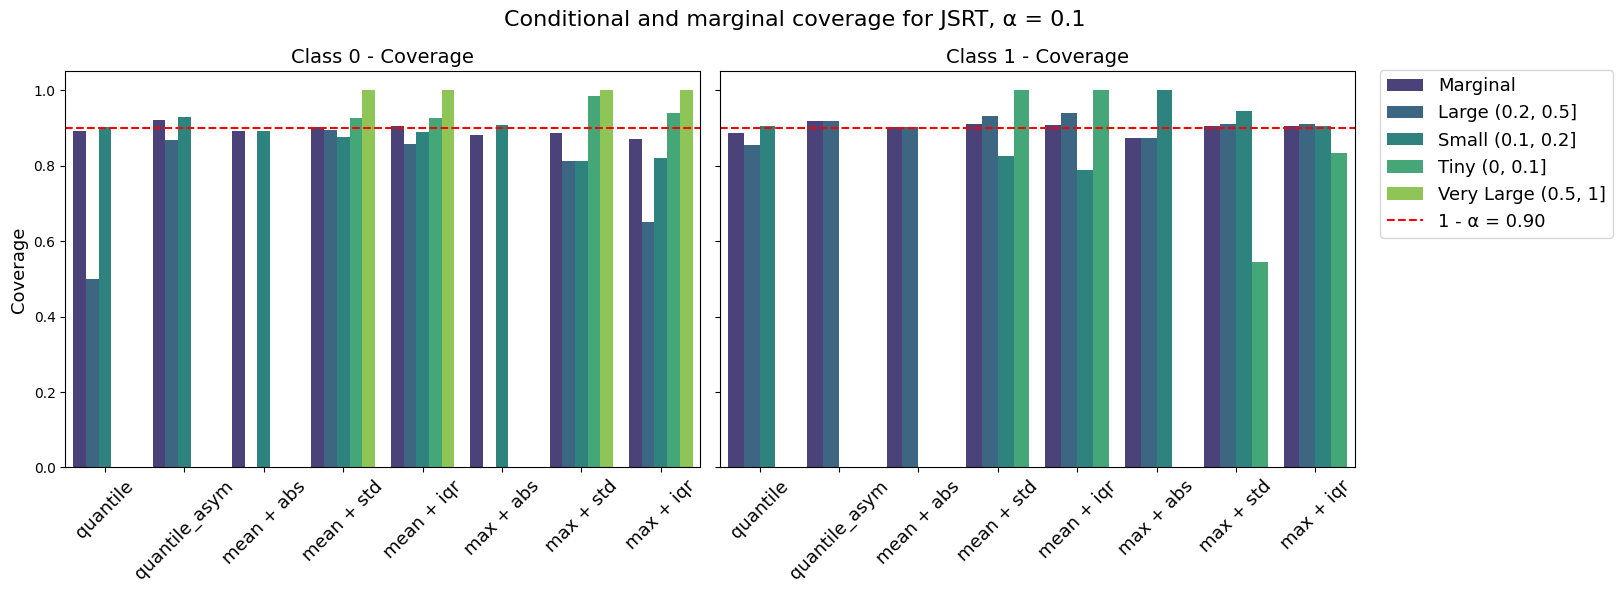

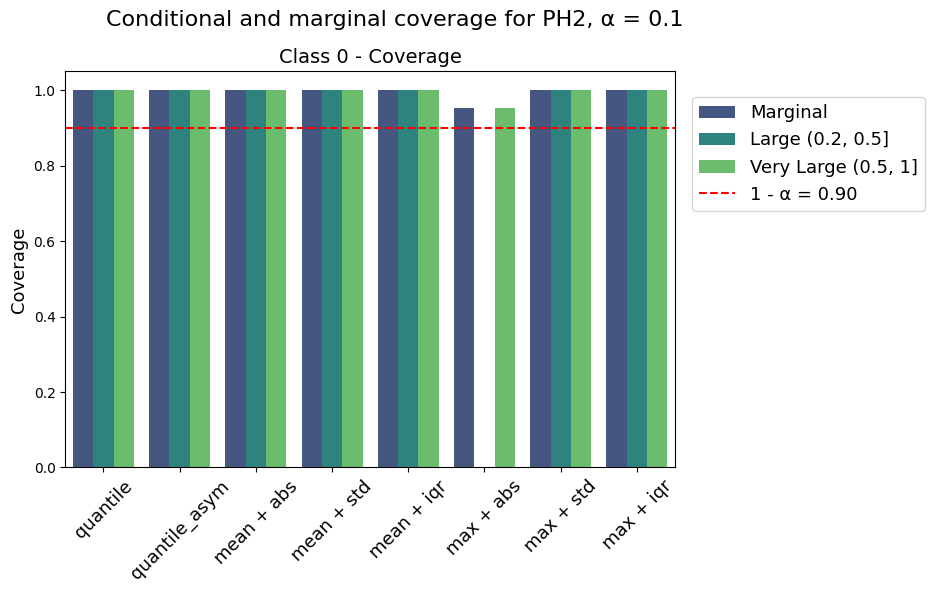

The palette list has more values (5) than needed (4), which may not be intended.


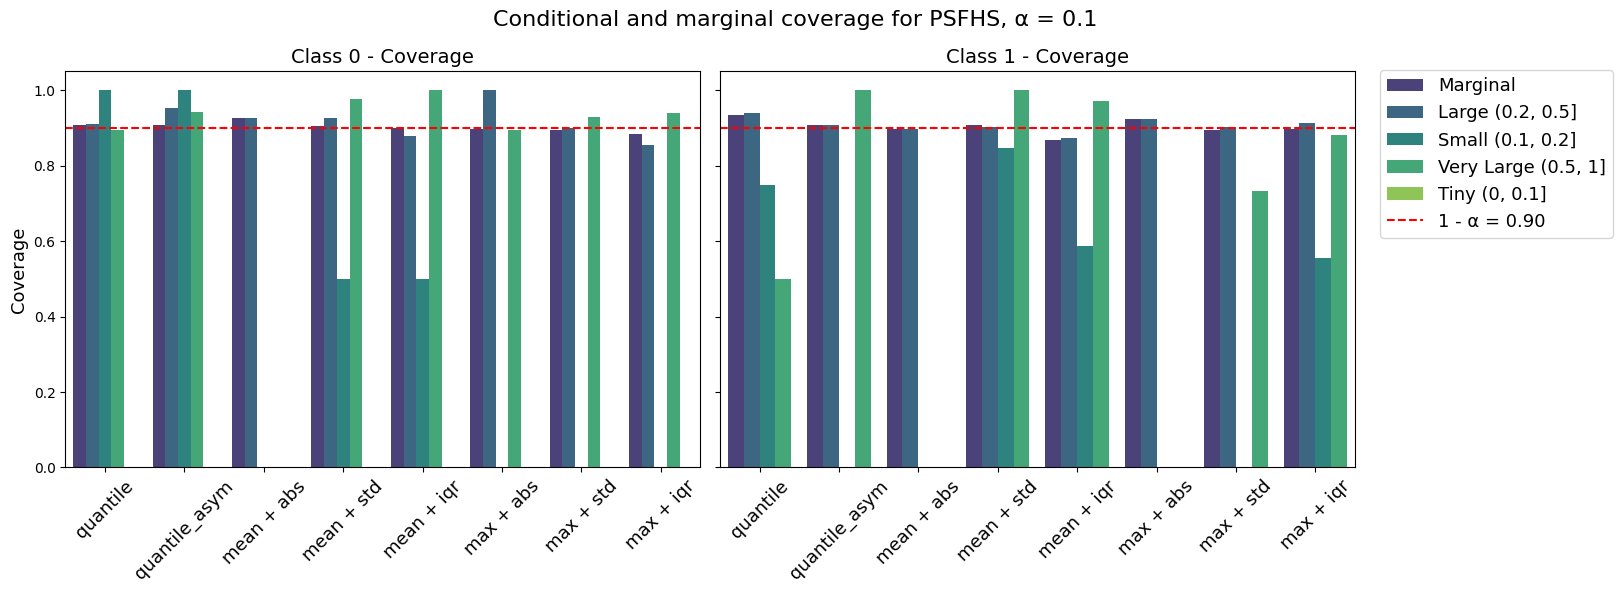

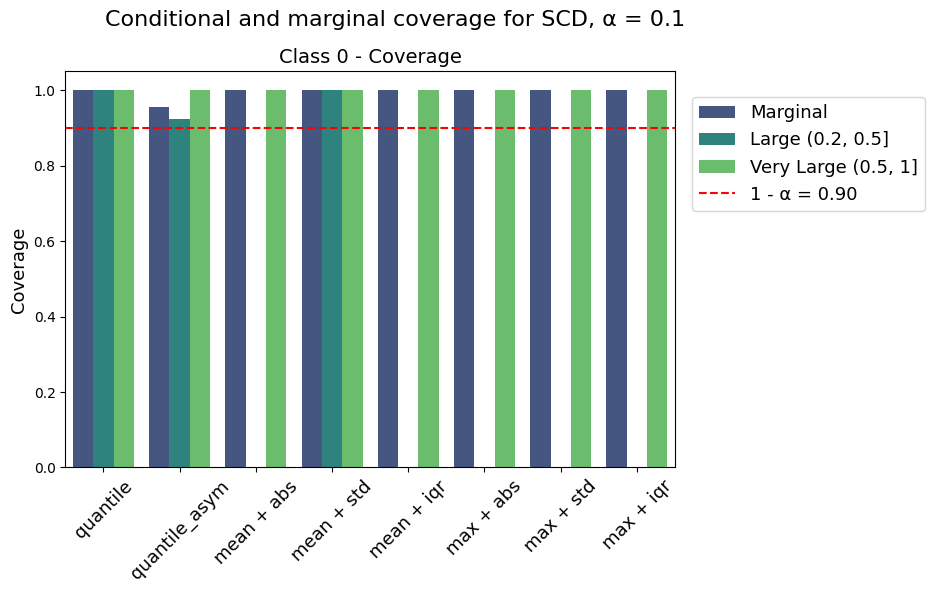

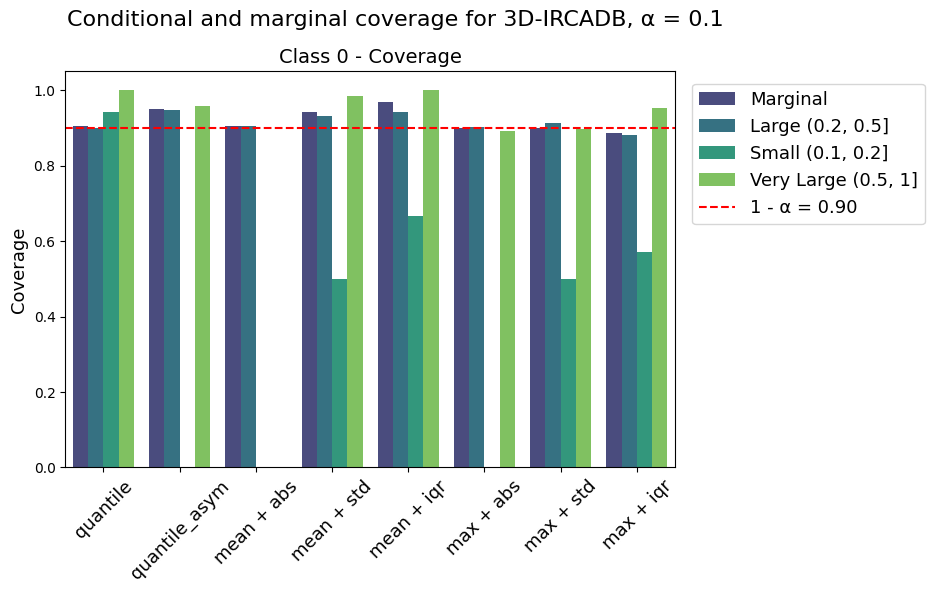

The palette list has more values (5) than needed (4), which may not be intended.


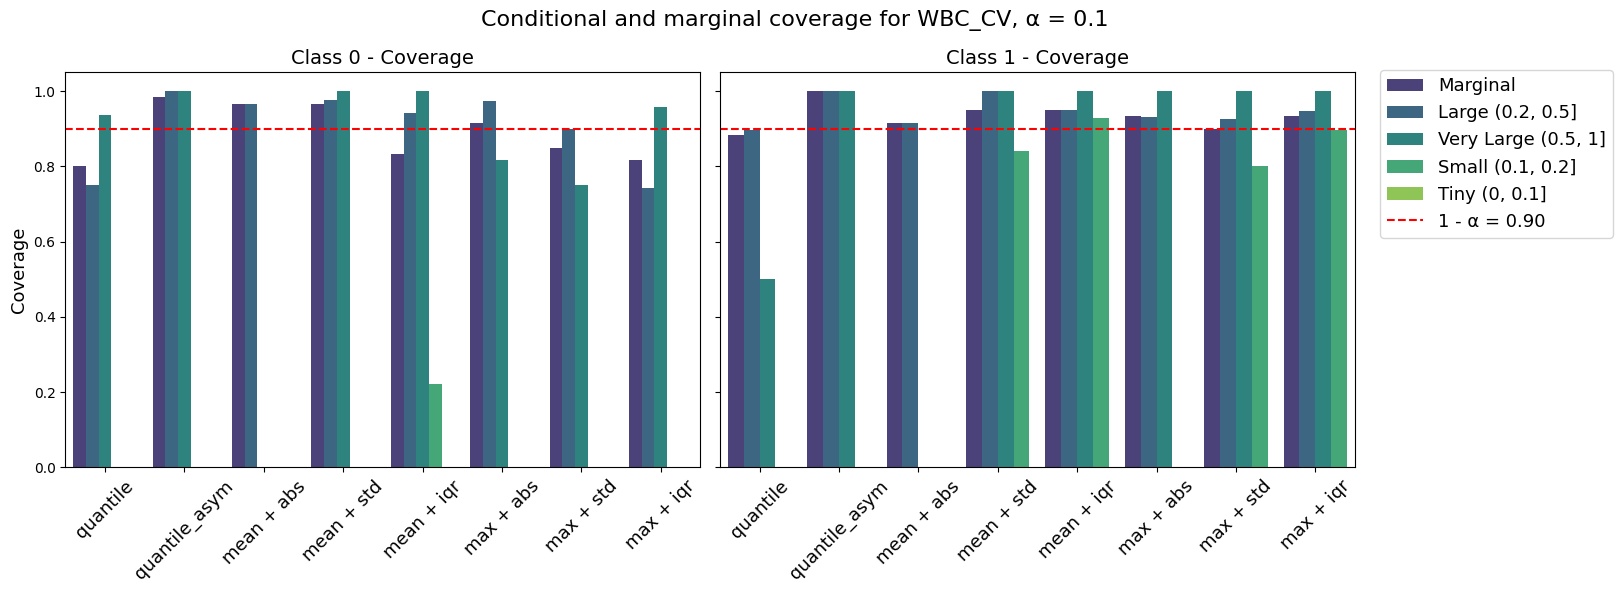

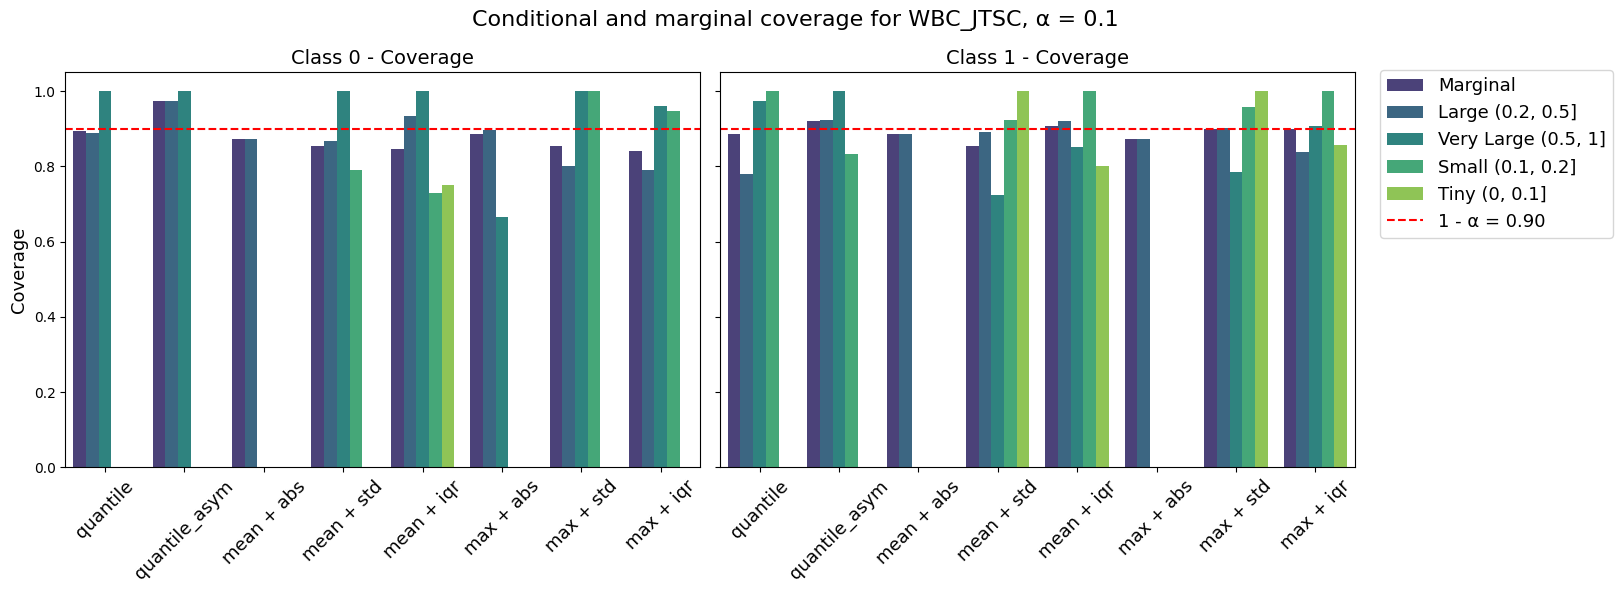

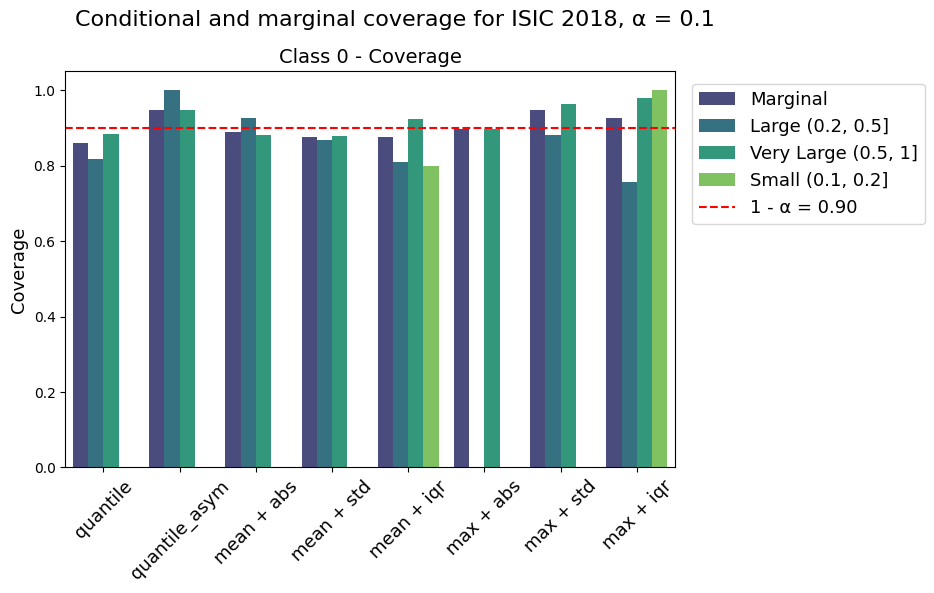

In [7]:
alpha = 0.1
combinations = [(e, s) for e in ['mean', 'max'] for s in ['abs', 'std', 'iqr']]

for dataset in datasets:
    conf_results = {}

    # Quantile based
    conf_results['quantile'] = quantile_calibrate(
        res_sam[dataset],
        p_l=0.4, p_h=0.95,
        alpha=alpha
    )


    conf_results['quantile_asym'] = quantile_calibrate_asymm(
        res_sam[dataset],
        p_l=0.4, p_h=0.95,
        alpha_l=0.02, 
        alpha_u=0.08
    )

    # Regression based
    for estimator, sigma_type in combinations:
        label = f'{estimator} + {sigma_type}'
        conf_results[label] = conformal_calibrate(
            res_sam[dataset],
            estimator=estimator,
            sigma_type=sigma_type,
            alpha=alpha,
        )

    # Plot for this dataset
    plot_coverage_analysis(conf_results, alpha=alpha, conditioning='width',
                           title=f'Conditional and marginal coverage for {dataset.upper()}, α = {alpha}')
